# P2P2Prosper: Analysis of Prosper Peer-to-Peer Loan Data 

## Research project performed by William J Townsend for Udacity, 22 Sep 2021 

## Investigation Overview

This presentation presents my conclusions and recommended courses of action regarding three observations from the Prosper peer-to-peer lending platform dataset, provided by Udacity. These three areas are: 

- Relationship between prior Prosper loans, investment by friends, and successful loan completion
- Examining the value of the 'recommendation' metric on Prosper
- Examining trends amongst the largest investors in the platform

## Dataset Overview

The Prosper dataset initially contains 85 variables, which were whittled down to 18 variables that I wanted to explore for the purposes of this project. In the end, 6 of these variables were used in this presentation. 

**Successful Loan Completion Rate:** This is the rate at which loans are successfully paid off. The dataset excluded current loans, only handling loans which have been completed, whether successfully (paid off) or not (defaulted/written off). 

**Loan Amount:** This is the amount of the requested loan, the amount agreed upon to be paid back, also called the principal. 

**Lost Principal:** This is the amount of principal that was lost for any loan that was not successfully completed. For example, on a \\$10,000 loan, if you paid back \\$8,000 (ignoring interest), the lost principal would be \\$2,000. On successfully completed loans, this is 0. In this presentation, this is generally expressed as a percentage of the loan amount. 

**Recommendations:** This is a Prosper platform metric functioning as a sort of "reputation" score, where users can be given recommendations by other users. 

**Prior Loans:** This is a Prosper platform metric indicating how many (if any) prior loans *on Prosper* the borrower has completed.

**Friends Invested:** On the Prosper platform, users can be "friends" with each other, and may invest into each other's loans. This specifically represents the number of such friends invested in a loan. The amount invested by friends is also available, which allows for a specific subset of interesting data to be examined in this presentation. 

In [6]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the CLEAN dataset from the SAVED CLEAN .csv
prosper = pd.read_csv('clean_prosper_data.csv')

In [4]:
# GENERATING NEEDED CHILD DATAFRAMES
# Copy prosper data to get rid of warning regarding copies of slices
investing_df = prosper.copy()
# Isolate dataframe to only those loans with 1 friend providing full investment to borrower
investing_df = investing_df[investing_df.friends_invest_amt == investing_df.loan_amt]
# Copy investing_df to manipulate
inv_fail_df = investing_df.copy()
# Isolate only loans which were failed
inv_fail_df = inv_fail_df[inv_fail_df['loan_status'] == 'Failed']
# Calculate percentage of principal loan amount lost
inv_fail_df['princip_pct_lost'] = inv_fail_df['lost_principal'] / inv_fail_df['loan_amt']
# Calculate percentage of principal loan amount paid
inv_fail_df['princip_pct_paid'] = (1 - inv_fail_df['princip_pct_lost'])
# Isolate percentage principal lost for failing loans with 1 friend providing full investment to borrower
single_investor_principal_pct_loss = inv_fail_df.princip_pct_lost.mean()


# Copy prosper dataframe to new dataframe of failed loans
fail_df = prosper.copy()
# Isolate only loans which were failed
fail_df = fail_df[fail_df['loan_status'] == 'Failed']
# Calculate percentage of principal loan amount lost
fail_df['princip_pct_lost'] = fail_df['lost_principal'] / fail_df['loan_amt']
# Calculate percentage of principal loan amount paid
fail_df['princip_pct_paid'] = (1 - fail_df['princip_pct_lost'])
# Isolate percentage principal lost for ALL failing loans
overall_principal_pct_loss = fail_df.princip_pct_lost.mean()

## How do prior Prosper loans and friends invested in a loan relate to successful loan completion?

The graph of success rate (left plot) is placed alongside the raw number of loans in each "bin" or "cell" (right plot) of this heatmap to provide some necessary context regarding how much weight can be placed in the accuracy of that success rate. These conclusions are concentrated on what can be concluded from the bottom left corner, as a result. 

At the 0, 0 bin (0 friends invested in the loan, 0 prior Prosper loans), we see a 67% successful loan completion rate, just under the success rate we see for the overall dataset. What is extremely promising about this data is that if a borrower gets 1 friend to invest in their loan (0, 1 on the heat map), that success rate goes up about 10%, about 74% likely to pay that loan off. Similarly, if a borrower has 1 prior completed loan through Prosper (1, 0 on the heatmap), their success rate for paying off a loan also increases about 10%, to 75% chance of success.

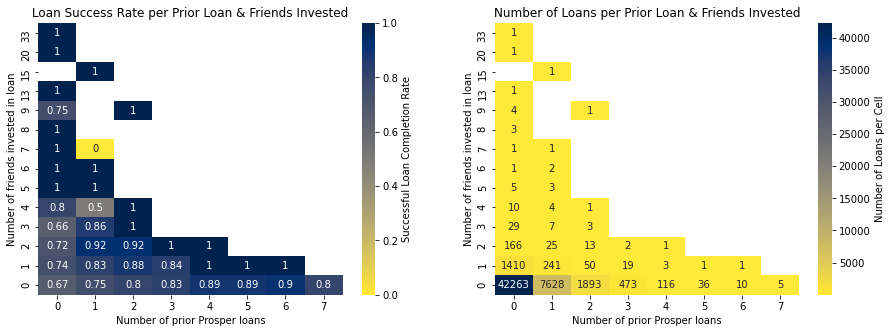

In [7]:
# Plotting friends_invested vs prior_loans vs loan_status
plt.figure(figsize = [15, 5])

# Plot 1: Heat map: friends_invested vs prior_loans vs percentage successful loan outcome
plt.subplot(1, 2, 1)
# Perform GROUP BY on friends_invested, calculate success rate for each prior_loan
succ_fipl = prosper.groupby(['friends_invested', 'prior_loans']).agg({'num_status' : np.mean})
# Use .reset_index to turn Series into dataframe object
succ_fipl = succ_fipl.reset_index()
# Rename column to indicate success rate
succ_fipl.rename(columns = {'num_status' : 'pct_success'}, inplace = True)
# Use pivot to rearrange the data into heat mappable rows/columns
succ_fipl = succ_fipl.pivot(index = 'friends_invested', columns = 'prior_loans', values = 'pct_success')
# Generate heatmap
sns.heatmap(succ_fipl, annot = True, cmap = 'cividis_r', cbar_kws={'label' : 'Successful Loan Completion Rate'});
# Invert y-axis to be consistent in direction
plt.gca().invert_yaxis();
# Plot polishing
plt.ylabel('Number of friends invested in loan');
plt.xlabel('Number of prior Prosper loans');
plt.title('Loan Success Rate per Prior Loan & Friends Invested');

# Plot 2: Heat map: friends_invested vs prior_loans vs number of loans
plt.subplot(1, 2, 2)
# Perform GROUP BY on friends_invested, calculate count for each prior_loan
n_fipl = prosper.groupby(['friends_invested', 'prior_loans']).size()
# Use .reset_index to turn Series into dataframe object
n_fipl = n_fipl.reset_index(name='count')
# Use pivot to rearrange the data into heat mappable rows/columns
n_fipl = n_fipl.pivot(index = 'friends_invested', columns = 'prior_loans', values = 'count')
# Generate heatmap
sns.heatmap(n_fipl, annot = True, fmt = 'g', cmap = 'cividis_r', cbar_kws={'label' : 'Number of Loans per Cell'});
# Invert y-axis to be consistent in direction
plt.gca().invert_yaxis();
# Plot polishing
plt.ylabel('Number of friends invested in loan');
plt.xlabel('Number of prior Prosper loans');
plt.title('Number of Loans per Prior Loan & Friends Invested');

If a borrower can get both 1 friend invested in their loan *AND* has 1 prior completed loan, their successful loan rate goes up another 10%. At this point, the prospective borrower has an 83% likelihood of successful repayment of the loan. While the size of this subset (1, 1) of the data is relatively small (n = 241), this is a significant improvement in success rate, and higher success rates mean safer investments for Prosper and its investing users. The data going further out (3+ along either axis) gets extremely volatile due to small sample sizes, but we do see promising trends along each axis with successful loan completion pushing towards 90%, along with the more substantive observations noted already. Getting borrowers to have prior loans, or to have friends investing in their loans, seems to have a legitimate positive impact on successful loan repayment, and Prosper needs to work to incentivize both behaviors amongst borrowers.

Regarding getting friends to invest, it may behoove Prosper to prompt borrowers generating a loan listing to get their friends to sign up for the platform and invest in their loan. While this could be done with a simple prompt, I suspect that not many users do this because asking friends for a loan is awkward and can be socially harmful. A way to push past this reluctance is to offer the borrower a lower APR if a friend invests a certain amount of money, and to calculate how much this would save the borrower over the long run. This creates a financial incentive for the borrower, who we already know is in need of money. This would require adjustment of the APR between loan listing and loan fulfillment, but this shouldn't be a significant problem. 

Regarding how to get more borrowers to have prior loans, this requires trying to get people into the Prosper ecosystem earlier on (perhaps with smaller loans, maybe with a certain maximum), getting them into the system and demonstrating an ability (or inability) to pay off loans successfully. I suspect that this is a marketing issue, where many people (especially those who may have lower financial literacy, which may coincide with worse credit as well) may not realize that peer-to-peer lending is an option and are simply dealing with the more exploitative elements of society and accepting it as "just the way it is". One area in particular which might be worth pursuing is marketing an alternative to the universally reviled payday loan treadmill, giving borrowers an option that allows them to stabilize their finances (and help their credit) while working to pay the loan back over a longer term than payday lenders provide. 

## What value is provided by Prosper's borrower "recommendation" counts?

Throughout my univariate and bivariate exploration, I noticed that 'recommendations' is a problematic statistic. I would contend that it should be removed (or at least, reset and significantly reworked) by Prosper as it is highly misleading in its current form.

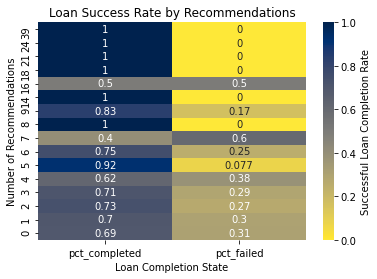

In [8]:
# Perform GROUP BY on recommendations, aggregate by successful completion rate
rec_pcts = prosper.groupby('recommendations').agg({'num_status' : np.mean})
# Calculate failure rate (1 - success rate)
rec_pcts['pct_failed'] = 1 - rec_pcts['num_status']
# Rename success rate appropriately
rec_pcts.rename(columns = {'num_status' : 'pct_completed'}, inplace=True)
# Generate heatmap
sns.heatmap(rec_pcts, annot = True, cmap = 'cividis_r', cbar_kws={'label' : 'Successful Loan Completion Rate'});
# Invert y-axis to be consistent in direction
plt.gca().invert_yaxis();
plt.ylabel('Number of Recommendations')
plt.xlabel('Loan Completion State')
plt.title('Loan Success Rate by Recommendations');

In this plot, we can see that as the number of recommendations increase, we do not see a trend of increasing successful loan completion. At 5+ recommendations, we're dealing with sample sizes of less than 15 (n = 1 or 2 for values beyond 9 recommendations) so the data at these points is very volatile. However, even at lower levels of recommendations, where we have a larger pool to study, we see success rates that differ only very, very slightly from the overall dataset.

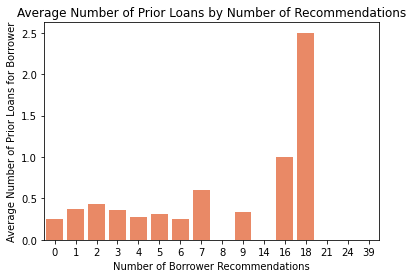

In [9]:
# Perform GROUP BY on recommendations, aggregate by average number of prior loans 
rec_vs_pl = prosper.groupby('recommendations').agg({'prior_loans' : np.mean})
# Rename mean number of prior loans appropriately
rec_vs_pl.rename(columns = {'prior_loans' : 'avg_prior_loans'}, inplace = True)
# Reset index to convert to plottable dataframe
rec_vs_pl = rec_vs_pl.reset_index()
# Generate barplot
sns.barplot(data = rec_vs_pl, x = 'recommendations', y = 'avg_prior_loans', color = 'coral');
plt.ylabel('Average Number of Prior Loans for Borrower')
plt.xlabel('Number of Borrower Recommendations')
plt.title('Average Number of Prior Loans by Number of Recommendations');

Intuitively, the main way that people earn feedback or reputation on a transaction-based site is by completing transactions and being "upvoted" or "recommended" somehow. In the case of a loan, the only way to complete a transaction in a positive fashion is to successfully pay off the loan. However, this plot demonstrates that for almost all numbers of recommendations present in the database, the average number of loans completed by that borrower is less than 1. On what basis is a borrower able to be "recommended", when they've never borrowed money before?

In several cases (borrowers with 8, 14, 21, 24, and 39 recommendations), the borrowers had absolutely no completed loans, and yet they had very large numbers of recommendations, relative to the whole. The most egregious example is the borrower with 39 loans. In this case, this borrower had 0 prior Prosper loans, and 33 friends contributed a total of \\$23,699 to the borrower's \\$25,000 loan. Presumably, the 33 friends were among the 39 users providing recommendations to this borrower, and while there may be some value to allowing "friends" to say "Hey, my friend here is trustworthy and you should loan them your money", their investment alone already indicates this. The fact that 33 friends invested in this borrower's loan is plenty meaningful. In essence, they've already put their money where their mouth is, so allowing this borrower's friends to generate a pile of recommendations is largely irrelevant.

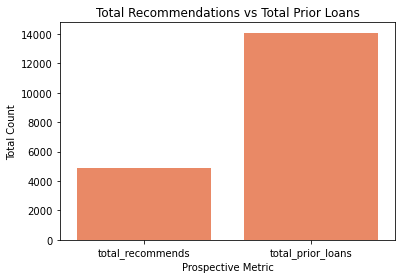

In [10]:
# Generate dictionary of labels/values
totals = {'total_recommends' : prosper.recommendations.sum(), 'total_prior_loans' : prosper.prior_loans.sum()}
# Generate series from dictionary
totals_s = pd.Series(totals)
# Generate bar plot of series
sns.barplot(x = totals_s.index, y = totals_s.values, color = 'coral');
plt.ylabel('Total Count')
plt.xlabel('Prospective Metric')
plt.title('Total Recommendations vs Total Prior Loans');

Finally, this last plot shows the total number of prior loans that exist in the dataset, as well as the total number of recommendations in the dataset. If each borrower who successfully completed a loan (a successful transaction) received +1 recommendation (or reputation), the two would be equal. Instead, we see that recommendations are far behind the number of prior loans, and while not all borrowers with prior loans have successfully paid off all of those prior loans, we know that 70% of borrowers pay off their loans successfully, with borrowers having prior loans doing so at a higher rate. When we take this discrepancy in conjunction with the fact that the vast majority of "recommended" borrowers have 0 previous loans at all, we can clearly conclude that recommendations are both A) not being given frequently enough to successful borrowers, and B) when they are given, they're not even being given to the right users.

Especially on a website allowing for financial transactions between users, any measure of reputation must be stringently protected and made sure to be as "true" as possible. The apparent ability for recommendations to be collected en masse by borrowers who've not even completed a single loan allows those borrowers to potentially mislead other users who may invest in their loan. Allowing for such behavior can render the "reputation" metric irrelevant to those informed of its inaccuracy, and misleading to those who are ignorant to this problem, such as new users of the platform. At a minimum, this harms the user experience, and at worst, it could potentially lead to legal liability for Prosper. The metric has only negative value, and as a result, it must be removed from the service, at least until it can be sufficiently modified to provide a positive value to users.

## What trends can we see amongst the largest investors in the platform?

In the univariate exploration of the amount invested into a borrower's loan by their friends, the majority of the investments was about what would be expected - mostly in the range of a couple hundred, with a few listings managing to get a few thousand out of friends and family as a sort of crowdfunding. However, 95 results were found with a single friend providing the full investment of the loan, which was unexpected.

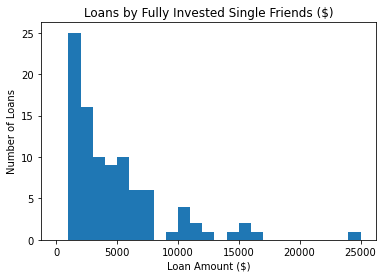

In [11]:
# Generate bins
invest_loan_bins = np.arange(0, 26000, 1000)
# Generate histogram of loan_amt
plt.hist(data = investing_df, x = 'loan_amt', bins = invest_loan_bins);
plt.ylabel('Number of Loans')
plt.xlabel('Loan Amount ($)')
plt.title('Loans by Fully Invested Single Friends ($)');

This plot shows the amounts being loaned by these single investors, ranging from \\$1,000 at the minimum to \\$25,000 at the maximum. Prosper's peer-to-peer lending model allows for investors to use the service as an investment like any other, so this sort of behavior is not against any rules, though it is unusual because it represents an aggressive strategy where many investors may want to mitigate their risk by diversifying their investments across borrowers. This can also indicate that people are using the platform as a way to formalize loan agreements between friends, which is also an intended use of the service. With the size of some of the investments happening here, it would be prudent for Prosper to keep a close eye on their most extreme transactions to ensure that Prosper is not being used as a vehicle for some sort of illicit activity, such as money laundering. There is potentially more to be learned here though, as it seems that these investors are being more successful in their investments than the overall population on Prosper.

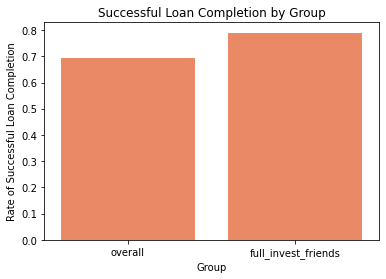

In [12]:
# Generate dictionary of labels/values
success_dict = {'overall' : prosper.num_status.mean(), 'full_invest_friends' : investing_df.num_status.mean()}
# Generate series from dictionary
success_s = pd.Series(success_dict)
# Generate bar plot of series
sns.barplot(x = success_s.index, y = success_s.values, color = 'coral');
plt.ylabel('Rate of Successful Loan Completion')
plt.xlabel('Group')
plt.title('Successful Loan Completion by Group');

This plot shows the rate of successful loan completion for the overall Prosper dataset (about 69%), relative to the same rate for the completed loans made by a fully invested single friend (79%). This is an improvement of just under 15%, and while the sample size is small (n = 95 for these loans), it is a promising result and certainly worthy of further investigation.

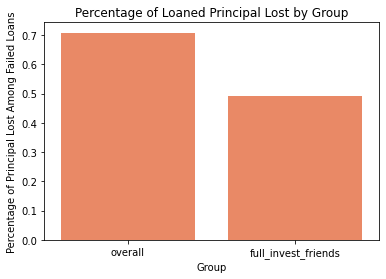

In [13]:
# Generate dictionary of labels/values
prin_loss_dict = {'overall' : overall_principal_pct_loss, 'full_invest_friends' : single_investor_principal_pct_loss}
# Generate series from dictionary
prin_loss_s = pd.Series(prin_loss_dict)
# Generate bar plot of series
sns.barplot(x = prin_loss_s.index, y = prin_loss_s.values, color = 'coral');
plt.ylabel('Percentage of Principal Lost Among Failed Loans')
plt.xlabel('Group')
plt.title('Percentage of Loaned Principal Lost by Group');

On any failed loan, there is a consideration of magnitude of failure for that loan for investors. If a loan of \\$10,000 is made, it's a better result for the investor for the borrower to have paid off 75\% of that loan, rather than 25\%, as the investor's loss is reduced in this circumstance. This final plot shows the average percentage of loan principal lost for both the group of fully invested single friends and the overall Prosper dataset. In addition to their larger overall success rate on loans, this group is enjoying a significantly improved rate of principal loss amount compared to the overall population of Prosper investors. Where a failed loan on Prosper results in an average loss of 71\% of the principal loaned, these investors see an average loss on their failed loans of just 49\% of the principal loaned. Across these two graphs, it's clear that this particular group of investors is taking fewer losses overall, and when they are taking a loss, the magnitude of that loss is significantly reduced. 

As mentioned, Prosper should be keeping a close eye on these most extreme users to ensure that nothing untoward is happening which may generate liability for Prosper or create a negative experience for users. While this is unlikely, it is prudent to govern oneself responsibly rather than to be taken advantage of or to have governance imposed upon a company (or the peer-to-peer lending industry as a whole) after an issue is brought to light. 

In keeping a close eye on these largest investors, it would also behoove Prosper to more closely examine how these investors are making their investment decisions, as such insights could help better quantify borrowers' risk for loan failure in the future. The publically provided dataset is almost exclusively concentrated on data about borrowers, with little to analyze from investors. For example, there is no way to tell whether or not one person made all 95 of these investments, or if 95 people made all 95 investments. This data, as well as other data regarding what information an investor has access to about a borrower, time spent researching loan listings, and any other gathered data about these investors would be extremely useful to try to understand the insight that these investors seem to have. 